## Импорты

In [1]:
import warnings
warnings.simplefilter('ignore')

import dill
import numpy as np
import pandas as pd
import requests
import shap
from lightfm import LightFM
from lightfm.data import Dataset
# from lightgbm import LGBMRanker, LGBMClassifier
from rectools.metrics import calc_metrics, NDCG, MAP, Precision, Recall, MeanInvUserFreq
from rectools import Columns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from typing import Any, Dict, Tuple
from tqdm.auto import tqdm
from zipfile import ZipFile

In [10]:
from typing import Callable, Dict, Set, List, Optional

import numpy as np
from lightfm import LightFM
from scipy.sparse import csr_matrix


def generate_lightfm_recs_mapper(
    model: LightFM, 
    N: int, 
    item_iids: List[int],  # iid - internal lfm id
    user_id_to_iid: Dict[int, int], 
    item_iid_to_id: Dict[int, int], 
    known_item_ids: Dict[int, Set[int]],
    user_features:  Optional[csr_matrix] = None, 
    item_features: Optional[csr_matrix] = None, 
    num_threads: int = 1,
) -> Callable:
    """Возвращает функцию для генерации рекомендаций в формате item_ids, scores"""
    def _recs_mapper(user):
        # Предикт для одного юзера
        user_id = user_id_to_iid[user]
        # Получаем список скоров. index - соответствует внутренним 
        # индексам lightfm для айтемов т.е. ключам из item_iid_to_id
        scores_vector = model.predict(user_id, item_iids, user_features=user_features,
                             item_features=item_features, num_threads=num_threads)
        # Оставляем запас для исключения уже просмотренного из рекомендаций
        additional_N = len(known_item_ids[user_id]) if user_id in known_item_ids else 0
        total_N = N + additional_N
        # Получаем список индексов топ-N айтемов
        top_iids = np.argpartition(scores_vector, -np.arange(total_N))[-total_N:][::-1]
        # Исключаем уже просмотренное из рекомендаций
        if additional_N > 0:
            filter_items = known_item_ids[user_id]
            top_iids = [item_index for item_index in top_iids if item_iid_to_id[item_index] not in filter_items]
        # Переводим индексы lightfm айтемов в их реальные id
        final_recs = [item_iid_to_id[item_index] for item_index in top_iids]
        # Сохраняем скоры
        final_scores = scores_vector[top_iids]
        return final_recs, final_scores
    return _recs_mapper


def avg_user_metric(
        y_true: np.ndarray,
        y_pred: np.ndarray,
        user_ids: np.ndarray,
        metric_function: Callable[[np.ndarray, np.ndarray], float],
) -> float:
    """
    Вычисляем метрику, усредненную по всем значимым (есть разные таргеты) группам.

    :param y_true: список таргетов
    :param y_pred: список предсказаний
    :param user_ids: список групп (обычно это список user_id той же размерности, что и предсказания и таргеты)
    :param metric_function: усредняемая метрика(y_true, y_pred) -> float
    :return: значение метрики metric_function, усредненное по всем значимым группам
    """
    avg_score: float = 0.

    if len(y_pred) == len(y_true) == len(user_ids):
        l_ind: int = 0
        cur_group_id: int = user_ids[0] if len(user_ids) else 0
        n_groups: int = 0
        for r_ind, group_id in enumerate(user_ids):
            if group_id != cur_group_id or r_ind == len(user_ids) - 1:
                if r_ind == len(user_ids) - 1:
                    r_ind += 1
                # Если группа не состоит из одного и того же таргета - добавляем ее
                group_true = y_true[l_ind: r_ind]
                if not np.all(group_true == group_true[0]):
                    avg_score += metric_function(group_true, y_pred[l_ind: r_ind])
                    n_groups += 1
                l_ind = r_ind
                cur_group_id = group_id
        avg_score /= max(1, n_groups)
    else:
        raise ValueError(f'Размерности не совпадают: '
                         f'y_pred - {len(y_pred)}, y_true - {len(y_true)}, user_ids - {len(user_ids)}')
    return avg_score

## Подготовка данных

In [11]:
interactions = pd.read_csv('data_original/interactions.csv')
users = pd.read_csv('data_original/users.csv')
items = pd.read_csv('data_original/items.csv')

In [12]:
print(interactions.shape)
interactions.head(3)

(5476251, 5)


,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0


In [13]:
# Меняем названия колонок для использования rectools
interactions.rename(
    columns={
        'last_watch_dt': Columns.Datetime,
        'watched_pct': Columns.Weight,
    }, 
    inplace=True,
) 
# Меняем тип данных
# interactions['datetime'] = interactions['datetime'].astype(np.datetime64)
interactions['datetime'] = pd.to_datetime(interactions['datetime'])

# Заполняем пропуски
interactions_default_values: Dict[str, Any] = {
   Columns.Datetime: interactions[Columns.Datetime].median(),
    Columns.Weight: 0.,
    'total_dur': 0,
}
interactions.fillna(interactions_default_values, inplace=True)

# Смотрим что получилось
interactions.head(10)

,user_id,item_id,datetime,total_dur,weight
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
5,1032142,6686,2021-05-13,11286,100.0
6,1016458,354,2021-08-14,1672,25.0
7,884009,693,2021-08-04,703,14.0
8,648682,1449,2021-06-13,26246,75.0
9,203219,13582,2021-08-22,6975,100.0


### `users`: данные о пользователях

- `age` бин по возрасту 
- `income` бин по доходу 
- `sex` пол 
- `kids_flg` флаг наличия детей

Все признаки - результат предсказания соцдем моделей

In [17]:
print(users.shape)
users.head(3)

(840197, 5)


,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0


In [18]:
def encode_cat_cols(df: pd.DataFrame, cat_cols) -> Tuple[pd.DataFrame, Dict]:
    cat_col_encoding = {}  # словарь с категориями

    # Тут мы могли бы заполнять пропуски как еще одну категорию,
    # но они и так заполняются таким образом автоматически ниже
    # default_values = {col: 'None' for col in cat_cols}
    # df.fillna(default_values, inplace=True)

    for col in cat_cols:
        cat_col = df[col].astype('category').cat
        cat_col_encoding[col] = cat_col.categories
        df[col] = cat_col.codes.astype('category')
    return df, cat_col_encoding

users_cat_cols = [
    # 'user_id',
     'age', 'income', 'sex', 'kids_flg'
]
users, users_cat_col_encoding = encode_cat_cols(users, users_cat_cols)

# None уже кодируется как -1
users_cat_col_encoding['income'], users['income'].unique()

(Index(['income_0_20', 'income_150_inf', 'income_20_40', 'income_40_60',
        'income_60_90', 'income_90_150'],
       dtype='object'),
 [4, 2, 3, 0, -1, 5, 1]
 Categories (7, int8): [-1, 0, 1, 2, 3, 4, 5])

In [26]:
users.head(3)

,user_id,age,income,sex,kids_flg
0,973171,1,4,1,1
1,962099,0,2,1,0
2,1047345,3,3,0,0


In [19]:
# Наиболее популярны income - income_40_60
users.describe(include='category')

,age,income,sex,kids_flg
count,840197,840197,840197,840197
unique,7,7,3,2
top,1,2,0,0
freq,233926,471519,425270,587209


### `items`: данные об айтемах

- `content_type` - тип контента
- `title` - название на русском
- `title_orig` - название оригинальное
- `release_year` - год выпуска
- `countries` - страны
- `for_kids` - флаг контент для детей
- `age_rating`- Возрастной рейтинг
- `studios` - студии
- `directors` - режиссеры
- `actors`- актеры
- `keywords` - ключевые слова 
- `description` - описание

In [20]:
print(items.shape)
items.head(3)

(15963, 14)


,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."


In [21]:
# Аналогичным образом кодируем категориальные колонки и пока удаляем текстовые
items_cat_cols = [ 
    'content_type', 'for_kids', 'studios',
]
items_text_cols = [
    'title', 'title_orig', 'genres', 'countries', 'directors', 'actors', 'description', 'keywords',
]
items_num_cols = [
    'release_year', 'age_rating', 
]
default_values_items = {
    'release_year': items['release_year'].median(),
    'age_rating': items['age_rating'].median(),
}

items, items_cat_col_encoding = encode_cat_cols(items, items_cat_cols) 
items = items.drop(items_text_cols, axis=1)
items.fillna(default_values_items, inplace=True)

items_cat_col_encoding['studios']

Index(['ABC', 'Amediateka', 'BBC', 'CBS', 'CBS All Access', 'Channel 4',
       'Cinemax', 'DAZN', 'Disney', 'Endemol', 'FX', 'Fox', 'Fremantle', 'HBO',
       'HBO Max', 'HBO, BBC', 'Legendary', 'MGM', 'New Regency Productions',
       'Paramount', 'Showtime', 'Sky', 'Sky, Fremantle', 'Sony Pictures',
       'Sony Pictures Television', 'Sony Pictures, рентв', 'Sony Plus',
       'Sony Plus, рентв', 'Starz', 'Universal', 'Universal, рентв',
       'Warner Bros', 'Warner Bros. Television', 'Ленфильм', 'Ленфильм, рентв',
       'Мосфильм', 'Рок фильм', 'рентв'],
      dtype='object')

## Трейн-вал-тест сплит

In [23]:
max_date = interactions[Columns.Datetime].max()
min_date = interactions[Columns.Datetime].min()

print(f'min дата в interactions: {min_date}')
print(f'max дата в interactions: {max_date}')
print(f'Продолжительность: {max_date - min_date}')

min дата в interactions: 2021-03-13 00:00:00
max дата в interactions: 2021-08-22 00:00:00
Продолжительность: 162 days 00:00:00


### Схема валидации
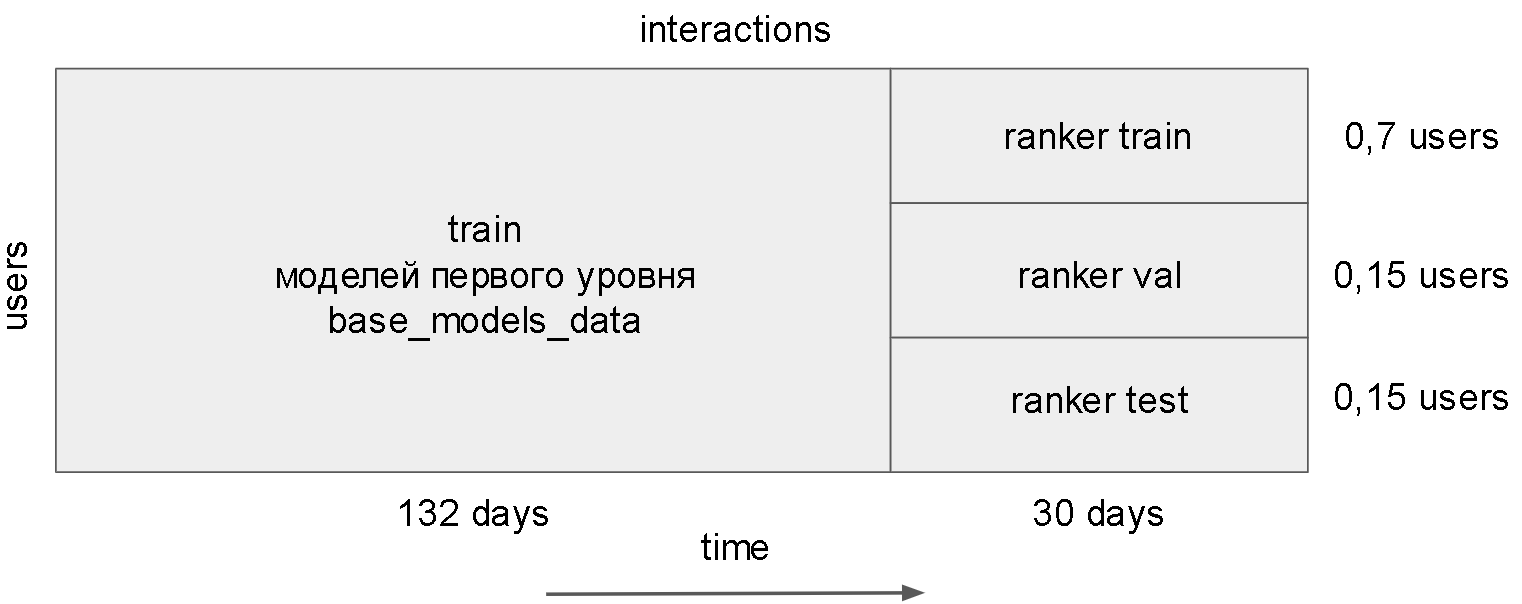

Разделение на горячих и холодных пользователей. Пользователь считается горячим, если у него более 10 взаимодействий

In [24]:
interactions_count = interactions.groupby("user_id")[["item_id"]].count().reset_index()

hot_users = interactions_count[interactions_count.item_id >= 10].user_id.values
cold_users = interactions_count[~(interactions_count.item_id >= 10)].user_id.values

hot_interactions = interactions[interactions["user_id"].isin(hot_users)].sort_values(["user_id", "datetime"])
user_type_dict = {i : 'hot' if i in hot_users else 'cold' for i in interactions_count.user_id.values}
        
print(len(hot_users), len(cold_users))

145410 816769


Модель первого уровня будет обучаться на горячих кандидатах. Холодным кандидатам будет предлагаться популярное

In [25]:
# Обучать ранжирование будем на последнем месяце (30 дней) не считая отложенной недели
ranker_days_count = 30

ranker_data = interactions[
    (interactions[Columns.Datetime] >= max_date - pd.Timedelta(days=ranker_days_count))
]

train_size = 0.7
val_size = 0.15
test_size = 0.15


train_val_users, test_users = train_test_split(
    ranker_data['user_id'].unique(), random_state=42, test_size=test_size
)

train_users, val_users = train_test_split(
    train_val_users, random_state=42, test_size=val_size / (train_size + val_size)  # 15% от общего размера
)

Подготовим данные для базовых моделей

In [33]:
# для LightFM
base_models_data = interactions[
    (interactions[Columns.Datetime] < max_date - pd.Timedelta(days=ranker_days_count))
]

base_models_data.shape

(3740952, 5)

In [34]:
# для UserKnn отделяем все оставшиеся взаимодействия горячих пользователей
base_models_data_knn = interactions[
    (interactions[Columns.Datetime] < max_date - pd.Timedelta(days=ranker_days_count)) &
    (interactions.user_id.isin(hot_users))
]
base_models_data_knn.shape

(2262613, 5)

## Обучаем модели первого уровня

### LightFM

In [35]:
lightfm_dataset = Dataset()
lightfm_user_ids = base_models_data['user_id'].unique()
lightfm_item_ids = base_models_data['item_id'].unique()
lightfm_dataset.fit(lightfm_user_ids, lightfm_item_ids)

В качестве таргета возьмем процент досмотра - - watched_pct (Columns.Weight)

In [36]:
interactions_matrix, weights_matrix = lightfm_dataset.build_interactions(
    zip(*base_models_data[['user_id', 'item_id', Columns.Weight]].values.T)
)
weights_matrix = weights_matrix.tocsr()

In [37]:
# Обучаем модель

lfm_model = LightFM(
    no_components=64, 
    learning_rate=0.1, 
    loss='warp', 
    max_sampled=5, 
    random_state=42,
)

num_epochs = 20

for _ in tqdm(range(num_epochs)):
    lfm_model.fit_partial(weights_matrix)

  0%|          | 0/20 [00:00<?, ?it/s]

In [40]:
# save model  
with open(f'lfm_model.dill', 'wb') as f:
    dill.dump(lfm_model, f)

#### Генерим кандидатов, которыми дополним датасет ранкера

In [41]:
# Маппинги обычных айдишников во внутренние индексы lightfm для юзеров и айтемов
lightfm_mapping = lightfm_dataset.mapping()
lightfm_mapping = {
    'user_id_to_iid': lightfm_mapping[0],  # iid - internal lfm id
    'item_id_to_iid': lightfm_mapping[2],
}
# Маппинги внутренние индексов lightfm в обычные айдишники для юзеров и айтемов
lightfm_mapping['user_iid_to_id'] = {v: k for k, v in lightfm_mapping['user_id_to_iid'].items()}
lightfm_mapping['item_iid_to_id'] = {v: k for k, v in lightfm_mapping['item_id_to_iid'].items()}

In [42]:
top_N = 100

# Внутренние индексы юзеров и айтемов lightfm (индексы матрицы user-item)
user_lfm_index = np.array(list(lightfm_mapping['user_id_to_iid'].values()))
item_lfm_index = np.array(list(lightfm_mapping['item_id_to_iid'].values()))

mapper = generate_lightfm_recs_mapper(
    model=lfm_model, 
    N=top_N,
    item_iids=item_lfm_index, 
    user_id_to_iid=lightfm_mapping['user_id_to_iid'],
    item_iid_to_id=lightfm_mapping['item_iid_to_id'],
    known_item_ids=dict(),  # тут можно добавить уже просмотренный контент для его исключения
    num_threads=4,
)

In [44]:
# Генерируем предсказания и получаем скоры и ранги lightfm

candidates = pd.DataFrame({'user_id': lightfm_user_ids})
candidates['item_id'], candidates['lfm_score'] = zip(*candidates['user_id'].map(mapper))
candidates = candidates.explode(['item_id', 'lfm_score'], ignore_index=True)
candidates['lfm_rank'] = candidates.groupby('user_id').cumcount() + 1 


In [45]:
# Делаем чекпоинт - сохраняем кандидатов
candidates.to_csv('data_original/candidates.csv', index=False)
candidates.head(3)

,user_id,item_id,lfm_score,lfm_rank
0,176549,11749,1.012975,1
1,176549,4475,0.932427,2
2,176549,13545,0.875368,3


In [47]:
# Считаем метрики
def calc_metrics_(candidates_df, rank_col: str) -> Dict[str, float]:
    metrics = {
        'ndcg@10': NDCG(k = 10),
        'map@10': MAP(k = 10),
        'Precision@10': Precision(k = 10),
        'recall@10': Recall(k = 10),
        'novelty@10': MeanInvUserFreq(k = 10),
    }
    return calc_metrics(
        metrics=metrics,
        reco=(
            candidates_df
            .rename(columns={rank_col: Columns.Rank})
            [[Columns.User, Columns.Item, Columns.Rank]]
            [candidates_df[Columns.User].isin(test_users)]
        ),
        interactions=(
            ranker_data
            [[Columns.User, Columns.Item, Columns.Datetime, Columns.Weight]]
            [ranker_data[Columns.User].isin(test_users)]
        ), 
        prev_interactions=(
            base_models_data
            [[Columns.User, Columns.Item, Columns.Datetime, Columns.Weight]]
            [base_models_data[Columns.User].isin(test_users)]
        ),
        catalog=items['item_id'].unique()
    )

models_metrics: Dict[str, Dict[str, float]] = dict()
models_metrics['lfm'] = calc_metrics_(candidates, 'lfm_rank')
models_metrics['lfm']

{'Precision@10': 0.020890826209077097,
 'recall@10': 0.07002662506974923,
 'ndcg@10': 0.02331144067713911,
 'map@10': 0.028402409873563787,
 'novelty@10': 4.428763914489864}

In [48]:
models_metrics: Dict[str, Dict[str, float]] = dict()
models_metrics['lfm'] = {'Precision@10': 0.020880082267892505,
 'recall@10': 0.07016524074728199,
 'ndcg@10': 0.0232367544621445,
 'map@10': 0.02830747440499919,
 'novelty@10': 4.424138616822346}

### UserKNN + Popular Recommender

In [49]:
from collections import Counter
from pathlib import Path
from typing import Dict
import scipy as sp
from implicit.nearest_neighbours import CosineRecommender, ItemItemRecommender, BM25Recommender, TFIDFRecommender

In [50]:
class UserKnn:
    """Class for fit-perdict UserKNN model
    based on ItemKNN model from implicit.nearest_neighbours
    """

    def __init__(self, model: ItemItemRecommender, N_users: int = 50):
        self.N_users = N_users
        self.model = model
        self.is_fitted = False

    def get_mappings(self, train):
        self.users_inv_mapping = dict(enumerate(train["user_id"].unique()))
        self.users_mapping = {v: k for k, v in self.users_inv_mapping.items()}

        self.items_inv_mapping = dict(enumerate(train["item_id"].unique()))
        self.items_mapping = {v: k for k, v in self.items_inv_mapping.items()}

    def get_matrix(
        self,
        df: pd.DataFrame,
        user_col: str = "user_id",
        item_col: str = "item_id",
        weight_col: str = "weight",
        users_mapping: Dict[int, int] = None,
        items_mapping: Dict[int, int] = None,
    ):

        if weight_col:
            weights = df[weight_col].astype(np.float32)
        else:
            weights = np.ones(len(df), dtype=np.float32)

        interaction_matrix = sp.sparse.coo_matrix(
            (
                weights,
                (
                    df[user_col].map(self.users_mapping.get),
                    df[item_col].map(self.items_mapping.get),
                ),
            )
        )

        return interaction_matrix

    def idf(self, n: int, x: float):
        return np.log((1 + n) / (1 + x) + 1)

    def _count_item_idf(self, df: pd.DataFrame):
        item_cnt = Counter(df["item_id"].values)
        item_idf = pd.DataFrame.from_dict(
            item_cnt, orient="index", columns=["doc_freq"]
        ).reset_index()
        item_idf["idf"] = item_idf["doc_freq"].apply(
                            lambda x: self.idf(self.n, x)
        )
        self.item_idf = item_idf

    def fit(self, train: pd.DataFrame):
        self.user_knn = self.model
        self.get_mappings(train)
        self.weights_matrix = self.get_matrix(
            train, users_mapping=self.users_mapping,
            items_mapping=self.items_mapping
        )

        self.n = train.shape[0]
        self._count_item_idf(train)

        self.user_knn.fit(self.weights_matrix)
        
        watched_items_df = (train.groupby("user_id")
                                 .agg({"item_id": list})
                                 .reset_index())
        self.watched_items = {}
        for _, row in watched_items_df.iterrows():
            self.watched_items[row["user_id"]] = row["item_id"]

        self.is_fitted = True

    def _generate_recs_mapper(
        self,
        model: ItemItemRecommender,
        user_mapping: Dict[int, int],
        user_inv_mapping: Dict[int, int],
        N: int,
    ):
        def _recs_mapper(user):
            user_id = user_mapping[user]
            recs = model.similar_items(user_id, N=N)
            return [user_inv_mapping[user] for user, _ in recs], [
                sim for _, sim in recs
            ]

        return _recs_mapper

    def predict(self, test: pd.DataFrame, N_recs: int = 100) -> list:
        
        if not self.is_fitted:
            raise ValueError("Please call fit before predict")
        
        mapper = self._generate_recs_mapper(
            model=self.user_knn,
            user_mapping=self.users_mapping,
            user_inv_mapping=self.users_inv_mapping,
            N=self.N_users,
        )
        recs = pd.DataFrame({"user_id": test["user_id"].unique()})
        recs["sim_user_id"], recs["sim"] = zip(*recs["user_id"].map(mapper))
        recs = recs.set_index("user_id").apply(pd.Series.explode).reset_index()
        recs = recs[recs["user_id"] != recs["sim_user_id"]]
        recs["item_id"] = recs["user_id"].apply(
            lambda x: self.watched_items.get(x, [])
        )
        recs = recs.explode("item_id")
        recs = recs.sort_values(["user_id", "sim"], ascending=False)
        recs = recs.drop_duplicates(["user_id", "item_id"], keep="first")
        recs = recs.merge(
            self.item_idf, left_on="item_id", right_on="index", how="left"
        )
        
        recs["score"] = recs["sim"] * recs["idf"]
        recs = recs.sort_values(["user_id", "score"], ascending=False)
        recs["rank"] = recs.groupby("user_id").cumcount() + 1
        recs = recs[recs["rank"] <= N_recs]
        
        return recs


In [52]:
def full_reco_items_list(
    arr_reco_after_model: np.array, pop_array: np.array, number: int
) -> list:
    """
    Add number of items from pop_array to arr_reco_after_model.
    Return array of 10 unique items
    """

    CONST_K = 100

    size_of_array = np.unique(arr_reco_after_model).size
    if size_of_array == CONST_K:
        return arr_reco_after_model

    # all duplicates will be deleting and adding some items from pop_array
    def del_repeat_items(full_arr_mix_pop: np.array, k: int = CONST_K) -> np.array:
        """
        Delete all duplicates items in array
        """

        size_of_array = np.unique(full_arr_mix_pop).size
        if size_of_array == CONST_K:
            return full_arr_mix_pop
        else:
            # delete duplicates and save the order of items
            full_arr_mix_pop = full_arr_mix_pop[
                np.sort(np.unique(full_arr_mix_pop, return_index=True)[1])
            ]
            # add new items from pop_array
            i = k - size_of_array
            full_arr_mix_pop = np.concatenate(
                (full_arr_mix_pop, np.random.choice(pop_array, i, replace=False))
            )
            return del_repeat_items(full_arr_mix_pop)

    full_arr_mix_pop = np.array([])
    full_arr_mix_pop = np.concatenate((arr_reco_after_model, pop_array[:number]))
    full_arr_mix_pop = del_repeat_items(full_arr_mix_pop)

    return list(full_arr_mix_pop)

# Если модель генерит меньше нужных 100 рекомендаций, дополняем популярным
def knn_make_predict(model, data: pd.DataFrame, list_pop_items: list) -> list:
    """
    Gets predict after bas-model and add lacking items(to 10)
    for each user if it needed
    """
    try: 
        predict = model.predict(data, 100)
        predict = predict["item_id"].unique()

        predict_len = len(predict)

        if predict_len < 100:
            #print(predict)
            predict = list(predict) + list_pop_items[:(100-predict_len)]


        return list(predict)
    
    except:
        return list_pop_items

In [53]:
userknn_hot_users = UserKnn(BM25Recommender(), 50)
userknn_hot_users.fit(base_models_data_knn)

  0%|          | 0/14517 [00:00<?, ?it/s]

In [54]:
with open("userknn_hot_users.dill", "wb") as f:
        dill.dump(userknn_hot_users, f)

In [55]:
def recommend_popular(
    df: pd.DataFrame, k: int = 10, days: int = 7
) -> list:
    """
    Returns most popular items for the last k days
    """

    min_date = df["datetime"].max().normalize() - pd.DateOffset(days)
    result = list(df.loc[df["datetime"] > min_date, "item_id"]
                   .value_counts()
                   .head(k)
                   .index.values)
    return result

In [56]:
popular_recs = recommend_popular(base_models_data_knn, 100)

In [57]:
candidates_knn_cold = pd.DataFrame({'user_id': cold_users})
candidates_knn_cold['item_id'] = candidates_knn_cold['user_id'].apply(lambda x: popular_recs)
candidates_knn_cold['knn_rank'] = candidates_knn_cold['user_id'].apply(lambda x: [*range(1,101)])

In [58]:
candidates_knn_cold = candidates_knn_cold.explode(['item_id', 'knn_rank'], ignore_index=True)

In [59]:
candidates_knn_hot = pd.DataFrame({'user_id': hot_users})
candidates_knn_hot['item_id'] = candidates_knn_hot['user_id'].apply(lambda x: knn_make_predict(userknn_hot_users, base_models_data_knn[base_models_data_knn.user_id == x][["user_id", "item_id", "weight"]], popular_recs) )
candidates_knn_hot['knn_rank'] = candidates_knn_hot['user_id'].apply(lambda x: [*range(1,101)])

In [60]:
candidates_knn_hot = candidates_knn_hot.explode(['item_id', 'knn_rank'], ignore_index=True)

In [61]:
candidates_knn = pd.concat([candidates_knn_cold, candidates_knn_hot], axis = 0)

In [62]:
candidates_knn.reset_index(drop=True, inplace = True)

candidates_knn['item_id'] = candidates_knn['item_id'].astype(int)
candidates_knn['knn_rank'] = candidates_knn['knn_rank'].astype(int)

In [ ]:
candidates_knn.to_csv('candidates_knn.csv', index=False)

In [63]:
models_metrics['knn_popular'] = calc_metrics_(candidates_knn, 'knn_rank')
models_metrics['knn_popular']

{'Precision@10': 0.0695516706828542,
 'recall@10': 0.28085631319825966,
 'ndcg@10': 0.07254576539293645,
 'map@10': 0.09293199153983464,
 'novelty@10': 3.253271584821371}

In [64]:
models_metrics['knn_popular'] = {'Precision@10': 0.05839332033828066,
 'recall@10': 0.2573846305610062,
 'ndcg@10': 0.06019492573507385,
 'map@10': 0.08425860717082494,
 'novelty@10': 4.0829298648106525}

In [4]:
candidates = pd.read_csv('candidates_knn.csv')

## Формируем датасет для ранкера

### Генерим фичи для ранкера

In [ ]:
# Получаем длину истории юзера 
base_models_data['user_hist'] = (
    base_models_data.groupby('user_id')
    ['item_id'].transform('count')
)
# Получаем популярность контента
base_models_data['item_pop'] = (
    base_models_data.groupby('item_id')
    ['user_id'].transform('count')
)
# Получаем среднюю популярность контента, просматриваемого этим юзером
base_models_data['user_avg_pop'] = (
    base_models_data.groupby('user_id')
    ['item_pop'].transform('mean')
)
# Получаем среднюю длину истории пользователя, которые смотрит этот контент
base_models_data['item_avg_hist'] = (
    base_models_data.groupby('item_id')
    ['user_hist'].transform('mean')
)
# Получаем популярность последнего просмотренного контента
base_models_data.sort_values(
    by=[Columns.User, Columns.Datetime], 
    ascending=[True, False], 
    ignore_index=True,
    inplace=True,
)
base_models_data['user_last_pop'] = (
    base_models_data.groupby('user_id')
    ['item_pop'].transform('first')
)


# Добавим еще фичей 

# медианное время просмотра пользователем
base_models_data['user_median_duratiation'] = (
    base_models_data.groupby('user_id')
    ['total_dur'].transform('median')
)

# 0.25 квантиль времени просмотра пользователем
base_models_data['user_q025_duratiation'] = (
    base_models_data.groupby('user_id')
    ['total_dur'].transform(lambda x: np.quantile(x, 0.25))
)

# 0.75 квантиль времени просмотра пользователем
base_models_data['user_q075_duratiation'] = (
    base_models_data.groupby('user_id')
    ['total_dur'].transform(lambda x: np.quantile(x, 0.75))
)


# медианное время просмотра контента всеми пользователями
base_models_data['item_median_duratiation'] = (
    base_models_data.groupby('item_id')
    ['total_dur'].transform('median')
)

# 0.25 кванитиль просмотра контента всеми пользователями
base_models_data['item_025_duratiation'] = (
    base_models_data.groupby('item_id')
    ['total_dur'].transform(lambda x: np.quantile(x, 0.25))
)


# 0.75 кванитиль просмотра контента всеми пользователями
base_models_data['item_075_duratiation'] = (
    base_models_data.groupby('item_id')
    ['total_dur'].transform(lambda x: np.quantile(x, 0.75))
)


# Получаем медианную популярность контента, просматриваемого этим юзером
base_models_data['user_median_pop'] = (
    base_models_data.groupby('user_id')
    ['item_pop'].transform('median')
)

# 0.25 кванитиль популярности контента, просматриваемого этим юзером 
base_models_data['user_025_quant_pop'] = (
    base_models_data.groupby('user_id')
    ['item_pop'].transform(lambda x: np.quantile(x, 0.25))
)

# 0.75 кванитиль популярности контента, просматриваемого этим юзером 
base_models_data['user_075_quant_pop'] = (
    base_models_data.groupby('user_id')
    ['item_pop'].transform(lambda x: np.quantile(x, 0.75))
)

# Получаем максимальную популярность контента, просматриваемого этим юзером
base_models_data['user_max_pop'] = (
    base_models_data.groupby('user_id')
    ['item_pop'].transform('max')
)

# Получаем минимальную популярность контента, просматриваемого этим юзером
base_models_data['user_min_pop'] = (
    base_models_data.groupby('user_id')
    ['item_pop'].transform('min')
)


In [34]:
# base_models_data = pd.read_csv('base_models_data_new.csv')

In [53]:
users_fts = [x for x in base_models_data.columns if 'user' in x][1:]
items_fts = [x for x in base_models_data.columns if 'item' in x][1:]
print(users_fts)
print(items_fts)

['user_hist', 'user_avg_pop', 'user_last_pop', 'user_median_duratiation', 'user_q025_duratiation', 'user_q075_duratiation', 'user_median_pop', 'user_025_quant_pop', 'user_075_quant_pop', 'user_max_pop', 'user_min_pop']
['item_pop', 'item_avg_hist', 'item_median_duratiation', 'item_025_duratiation', 'item_075_duratiation']


In [68]:
# Добавляем новые фичи в соответствующие таблички
items = pd.merge(
    left=items, 
    right=(
        base_models_data
        [['item_id'] + items_fts]
        .drop_duplicates()
    ),
    how='left',
    on='item_id',
)

users = pd.merge(
    left=users, 
    right=(
        base_models_data
        [['user_id'] + users_fts]
        .drop_duplicates()
    ),
    how='left',
    on='user_id',
)
users.head(3)

,user_id,age,income,sex,kids_flg,user_hist,user_avg_pop,user_last_pop,user_median_duratiation,user_q025_duratiation,user_q075_duratiation,user_median_pop,user_025_quant_pop,user_075_quant_pop,user_max_pop,user_min_pop
0,973171,1,4,1,1,5.0,19550.800000,93403.0,7361.0,6520.0,91345.0,743.0,645.0,2633.0,93403.0,330.0
1,962099,0,2,1,0,13.0,1329.307692,260.0,4676.0,3236.0,8010.0,901.0,330.0,1384.0,6112.0,246.0
2,1047345,3,3,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
# Обновляем дефолтные значения
# Прямо сейчас обновлять таблички users и items не обязательно, 
# сделаем это при джойне с кандидатами

# Для новых фичей айтемов
#default_values_items['item_pop'] = base_models_data['item_pop'].median()
#default_values_items['item_avg_hist'] = base_models_data['item_avg_hist'].median()

for i in items_fts:
    default_values_items[i] = base_models_data[i].median()

# Для новых фичей юзеров
default_values_users = {
    'user_hist': 0,
}

for i in users_fts[1:]:
    default_values_users[i] = base_models_data[i].median()

In [55]:
default_values_users, default_values_items

({'user_hist': 0,
  'user_avg_pop': 11957.864864864863,
  'user_last_pop': 2858.0,
  'user_median_duratiation': 4146.0,
  'user_q025_duratiation': 897.0,
  'user_q075_duratiation': 6889.0,
  'user_median_pop': 2521.0,
  'user_025_quant_pop': 1068.5,
  'user_075_quant_pop': 7541.0,
  'user_max_pop': 93403.0,
  'user_min_pop': 246.0},
 {'release_year': 2014.0,
  'age_rating': 16.0,
  'item_pop': 2846.0,
  'item_avg_hist': 22.67597765363129,
  'item_median_duratiation': 4268.0,
  'item_025_duratiation': 584.0,
  'item_075_duratiation': 7012.0})

### Джойним кандидатов и юзер/айтем фичи

In [7]:
# Загружаем список айтемов-кандидатов. 

candidates = pd.read_csv('candidates_knn.csv')
candidates.head(3)

,user_id,item_id,knn_rank
0,0,13865,1
1,0,9728,2
2,0,3734,3


In [8]:
# Вспоминаем про наши выборки интеракций для ранкера.
# Мы отобрали юзеров для обучения, валидации и теста.
# Оставляем среди них только тех, для кого есть и рекомы и таргеты

def users_filter(
    user_list: np.ndarray,
    candidates_df: pd.DataFrame, 
    df: pd.DataFrame,
) -> pd.DataFrame:
    # Джойним интеракции на наших кандидатов для юзеров из трейна, вал и теста
    df = pd.merge(
        df[df['user_id'].isin(user_list)], 
        candidates_df[candidates_df['user_id'].isin(user_list)], 
        how='outer',  
        on=['user_id', 'item_id']
    )
    # Проставляем дефолтные значения интеракций
    max_rank: int = df['knn_rank'].max() + 1  # 101
    
    default_values = {
        'knn_rank': max_rank,
        # Важно использовате те же дефолтные значения для интеракций, 
        # чтобы не сделать утечку
        **interactions_default_values,
    }
    df.fillna(default_values, inplace=True)
        
    # Сортируем по user_id - это пригодится для вычисления рангов и групп для ранжирования
    df.sort_values(
        by=['user_id', 'item_id'],
        inplace=True,
    )
    return df


In [26]:
ranker_train = users_filter(train_users, candidates, ranker_data)

In [27]:

ranker_val = users_filter(val_users, candidates, ranker_data)
ranker_test = users_filter(test_users, candidates, ranker_data)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,knn_rank
1180642,3,47,2021-08-16,2179.0,27.0,101.0
998971,3,142,2021-08-13,5892.0,100.0,101.0
1067328,3,965,2021-08-16,5813.0,96.0,101.0


In [56]:
# Добавляем фичи
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = pd.merge(
        df, 
        users, 
        how='left', 
        on=['user_id']
    )
    df = pd.merge(
        df, 
        items, 
        how='left', 
        on=['item_id']
    )

    # При джойне могут получиться строки с несуществующими айтемами или юзерами.
    # Надо заполнить пропуски. Используем заготовленные дефолтные значения,
    # чтобы не сделать утечку
    df.fillna(default_values_items, inplace=True)
    df.fillna(default_values_users, inplace=True)

    # Категориальные фичи закодированы пандасом так, что None === -1
    # Если изначально пропусков не было, то нужно добавить такое значение категории
    for col in df.columns:
        if isinstance(df[col].dtype, pd.CategoricalDtype):
            if -1 not in df[col].cat.categories:
                df[col] = df[col].cat.add_categories(-1)
            df.fillna({col: -1}, inplace=True)
    return df

In [ ]:
ranker_train = add_features(ranker_train)

In [ ]:
ranker_val = add_features(ranker_val)
ranker_test = add_features(ranker_test)

In [39]:
# Датасеты готовы, остались только таргеты, 
# которые можно посчитать на основе колонок total_dur и watched_pct

# Делаем еще один чекпоинт.

for name in ['train', 'val', 'test']:
    path: str = f'data/ranker_{name}.fth'
    locals()[f'ranker_{name}'].to_feather(path)

## Обучаем ранкер
### Pointwise

In [52]:
# Загружаем данные
for name in ['train', 'val', 'test']:
    path: str = f'data/ranker_{name}.fth'
    locals()[f'ranker_{name}'] = pd.read_feather(path)

In [ ]:
# таргет бинарный, так что - 
# будем считать просмотр хорошим если доля досмотра больше половины

def add_target(df: pd.DataFrame) -> pd.DataFrame:
    df['target'] = df[Columns.Weight] > 50  # 'watched_pct'
    df['target'] = df['target'].astype(int)
    return df

ranker_train = add_target(ranker_train)
ranker_val = add_target(ranker_val)
ranker_test = add_target(ranker_test)

In [42]:
# В train и val можно удалить 'плохих' пользователей, 
# Например тех у кого слишком много или мало просмотров или 
# тех для которых нет достаточного количества рекомендаций от Knn
# Тестовую группу не меняем

def filter_group(df: pd.DataFrame) -> pd.DataFrame:
    df.sort_values(
        by=['user_id', 'item_id'],
        inplace=True,
    )
    groups_df = (
        df[['user_id', 'item_id']]
        .groupby(by=['user_id']).count()
        .rename(columns={'item_id': 'group_size'})
    )
    df = pd.merge(
        df, 
        groups_df, 
        how='left', 
        on=['user_id']
    )
    # Удаляем группы, без достаточного числа просмотров/кандидатов
    df = df[df['group_size'] >= 100]

    # Колонка больше не нужна
    df.drop(columns=['group_size'], inplace=True)
    
    # Исправляем баг, с outher join в users_filter
    df = df[df['knn_rank'] <= 100]
    
    return df

ranker_train = filter_group(ranker_train)
ranker_val = filter_group(ranker_val)
# ranker_test = filter_group(ranker_test)

In [44]:
# Убираем ненужные айдишники, временные метки и таргеты.
# Для обучения используются только cols:
cols = [
    'knn_rank', 
    'age', 'income', 'sex', 'kids_flg',
    'user_hist', 'user_avg_pop', 'user_last_pop', 'user_median_duratiation', 
    'user_q025_duratiation', 'user_q075_duratiation', 'user_median_pop', 
    'user_025_quant_pop', 'user_075_quant_pop', 'user_max_pop', 'user_min_pop',
    'content_type', 'release_year', 'for_kids', 'age_rating', 'studios', 
    'item_pop', 'item_avg_hist', 'item_median_duratiation', 'item_025_duratiation', 'item_075_duratiation'
]
# Из них категориальные:
cat_cols = [
    'age', 'income', 'sex', 'kids_flg',
    'content_type', 'for_kids', 'studios',
]

In [ ]:
params = {
    'objective': 'binary',
    'n_estimators': 10000,  # максимальное число деревьев
    'max_depth': 4,  # максимальная глубина дерева
    'num_leaves': 10,  # число листьев << 2^max_depth
    'min_child_samples': 100,  # число примеров в листе
    'learning_rate': 0.25,  # шаг обучения
    'reg_lambda': 1,  # L2 регуляризация
    'colsample_bytree': 0.9,  # доля колонок, которая используется в каждом дереве
    'random_state': 42,
}
early_stopping_rounds = 32
fit_params = {
    'X': ranker_train[cols],
    'y': ranker_train['target'],
    'eval_set': [(ranker_val[cols], ranker_val['target'])],
    'eval_metric': 'logloss',
    'early_stopping_rounds': early_stopping_rounds,
    'categorical_feature': cat_cols,
    'feature_name': cols,
    'verbose': early_stopping_rounds / 8,
}
pointwise_model = LGBMClassifier(**params)
pointwise_model.fit(**fit_params)

In [12]:
# save model  
with open(f'models/pointwise_model.dill', 'wb') as f:
    dill.dump(pointwise_model, f)

In [13]:
# Смотрим на логлосс на валидации
pointwise_model.best_score_['valid_0']['binary_logloss']

0.0394652469075403

In [14]:
# SHAP - values
explainer = shap.Explainer(pointwise_model)
shap_values = explainer(ranker_test[cols].iloc[:10_000])

# lightGBM returns probabilities for both classes and I have to modify the SHAP values as
shap_values.values = shap_values.values[:,:,1]
shap_values.base_values = shap_values.base_values[:,1]

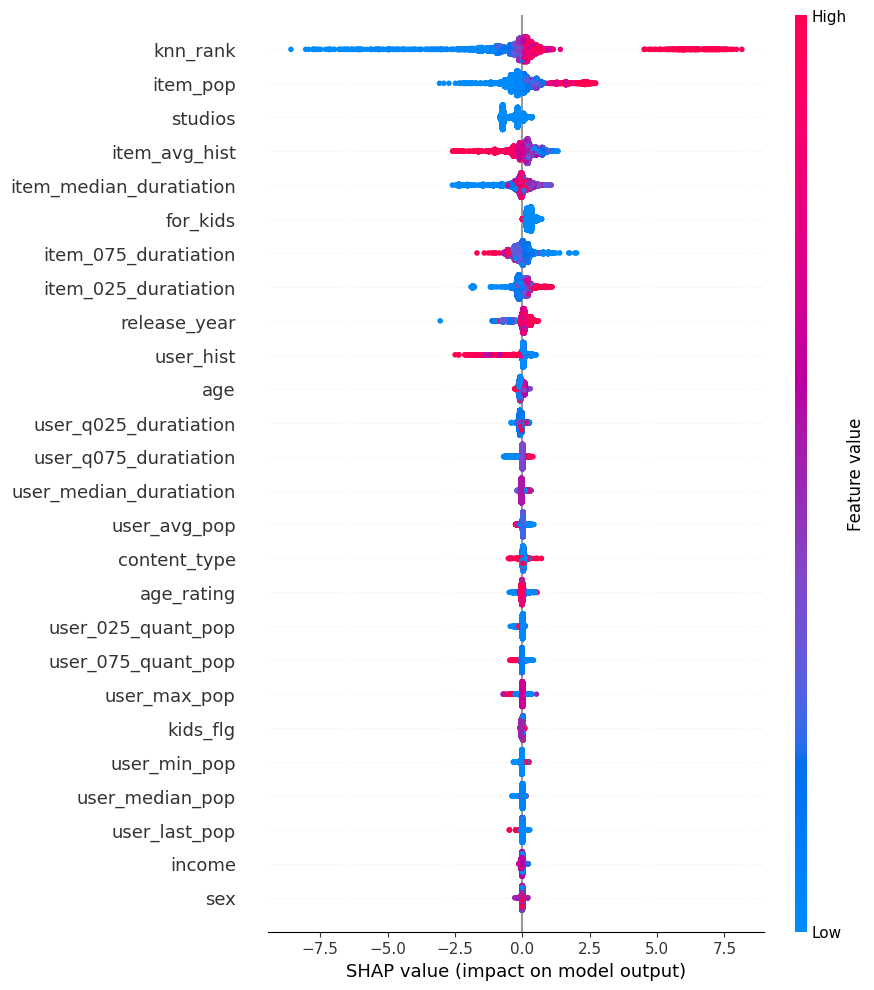

In [15]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=len(cols))

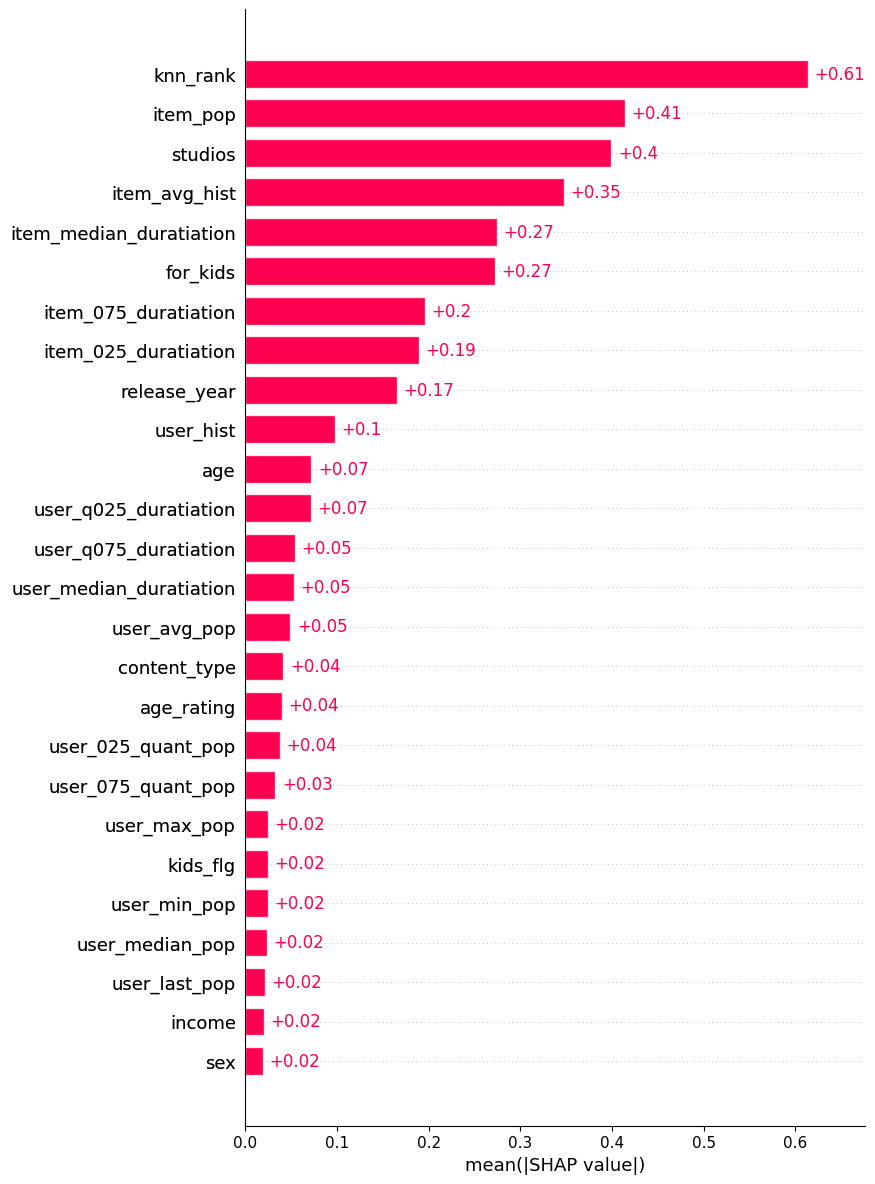

In [16]:
# mean shap-values
shap.plots.bar(shap_values, max_display=len(cols))

In [17]:
# Получаем предсказания для тестовых юзеров
y_pred: np.ndarray = pointwise_model.predict_proba(ranker_test[cols])[:, 1]
y_true: np.ndarray = np.array(ranker_test['target'])

y_pred

array([0.00277117, 0.00052769, 0.00017571, ..., 0.00335048, 0.00063627,
       0.00053399])

In [13]:
def add_score_and_rank(df: pd.DataFrame, y_pred_scores: np.ndarray, name: str) -> pd.DataFrame:
    # Добавляем скор модели второго уровня
    df[f'{name}_score'] = y_pred_scores
    # Добавляем ранг модели второго уровня
    df.sort_values(
        by=['user_id', f'{name}_score'],
        ascending=[True, False],
        inplace=True,
    )
    df[f'{name}_rank'] = df.groupby('user_id').cumcount() + 1

    # Исключаем айтемы, которые не были предсказаны на первом уровне
    mask = (df['knn_rank'] < 101).to_numpy()
    # Добавляем общий скор двух-этапной модели
    eps: float = 0.001
    min_score: float = min(y_pred_scores) - eps
    df[f'{name}_hybrid_score'] = df[f'{name}_score'] * mask
    df[f'{name}_hybrid_score'].replace(
        0,
        min_score,
        inplace=True,
    )
    # Добавляем общий ранг двух-этапной модели
    df[f'{name}_hybrid_rank'] = df[f'{name}_rank'] * mask
    max_rank: int = 101
    df[f'{name}_hybrid_rank'].replace(
        0,
        max_rank,
        inplace=True,
    )
    return df

In [ ]:
ranker_test = add_score_and_rank(ranker_test, y_pred, 'pointwise')

In [19]:
# усредненный рок аук по юзерам
# df должен быть отсортирован по user_id
(
    avg_user_metric(
        y_true=np.array(ranker_test['target']),
        y_pred=np.array(ranker_test['pointwise_score']),
        user_ids=np.array(ranker_test['user_id']),
        metric_function=roc_auc_score
    ), 
    avg_user_metric(
        y_true=np.array(ranker_test['target']),
        y_pred=np.array(ranker_test['pointwise_hybrid_score']),
        user_ids=np.array(ranker_test['user_id']),
        metric_function=roc_auc_score
    )
)

(0.9384083165686217, 0.40131153714016216)

In [43]:
# Получим значения метрик
models_metrics['pointwise'] = calc_metrics_(ranker_test, 'pointwise_rank')
models_metrics['pointwise_hybrid'] = calc_metrics_(ranker_test, 'pointwise_hybrid_rank')

pd.DataFrame(models_metrics)[['lfm', 'knn_popular', 'pointwise', 'pointwise_hybrid']]

,lfm,knn_popular,pointwise,pointwise_hybrid
Precision@10,0.020880,0.058393,0.271447,0.053135
recall@10,0.070165,0.257385,0.800389,0.256736
ndcg@10,0.023237,0.060195,0.362759,0.060780
map@10,0.028307,0.084259,0.676406,0.131028
novelty@10,4.424139,4.082930,4.507067,2.990717


### Pairwise/Listwise

In [26]:
# Для обучения ранжированию нужно правильно сформировать группы. 
# В нашем случае группа равна одному юзеру.
# Для LGBMRanker нужно задать отсортированный по юзерам (группам) датафрейм,
# для которого списком групп будет список из количества 
# ранжируемых айтемов на каждого юзера (группу).

# Официальная [дока|https://lightgbm.readthedocs.io/en/v3.3.2/pythonapi/lightgbm.LGBMRanker.html?highlight=ranker]:
# sum(group) = n_samples. 
# For example, if you have a 100-document dataset with 
# group = [10, 20, 40, 10, 10, 10], that means that you have 6 groups, 
# where the first 10 records are in the first group

# Важно! Если вы решите использовать CatBoostRanker или XGBoostRanker - там группы строятся по-другому.

def get_group(df: pd.DataFrame) -> np.ndarray:
    return np.array(
        df[['user_id', 'item_id']]
        .groupby(by=['user_id']).count()
        ['item_id']
    )

In [27]:
# Добавим таргет посложнее

def add_target(df: pd.DataFrame) -> pd.DataFrame:
    """
    0 - доля досмотра < 0.15
    1 - 0.15 <= доля досмотра < 0.75
    2 - 0.75 <= доля досмотра
    """
    df['target_ranker'] = (df[Columns.Weight] >= 15).astype(int)  # 'watched_pct'
    df['target_ranker'] += (df[Columns.Weight] >= 75).astype(int)
    return df

ranker_train = add_target(ranker_train)
ranker_val = add_target(ranker_val)
ranker_test = add_target(ranker_test)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,knn_rank,age,income,sex,kids_flg,...,release_year,for_kids,age_rating,studios,item_pop,item_avg_hist,item_median_duratiation,item_025_duratiation,item_075_duratiation,target_ranker
0,3,47,2021-08-16,2179.0,27.0,101.0,-1,-1,-1,-1,...,2017.0,-1,18.0,-1,1249.0,38.180144,7535.0,1270.00,8895.00,1
1,3,142,2021-08-13,5892.0,100.0,101.0,-1,-1,-1,-1,...,2020.0,-1,16.0,-1,35862.0,15.251464,4953.0,807.00,6205.00,2
2,3,965,2021-08-16,5813.0,96.0,101.0,-1,-1,-1,-1,...,2018.0,-1,12.0,-1,536.0,29.130597,3450.5,665.75,6774.25,2


In [30]:
params = {
    'objective': 'lambdarank',  # lambdarank, оптимизирующий ndcg 
    'n_estimators': 10000,  # максимальное число деревьев
    'max_depth': 4,  # максимальная глубина дерева
    'num_leaves': 10,  # число листьев << 2^max_depth
    'min_child_samples': 100,  # число примеров в листе
    'learning_rate': 0.25,  # шаг обучения
    'reg_lambda': 1,  # L2 регуляризация
    'colsample_bytree': 0.9,  # доля колонок, которая используется в каждом дереве
    'random_state': 42,
}
early_stopping_rounds = 32
fit_params = {
    'X': ranker_train[cols],
    'y': ranker_train['target_ranker'],
    'group': get_group(ranker_train),
    'eval_set': [(ranker_val[cols], ranker_val['target_ranker'])],
    'eval_group': [get_group(ranker_val)],
    'eval_metric': 'ndcg',
    'eval_at': (3, 5, 10),
    'early_stopping_rounds': early_stopping_rounds,
    'categorical_feature': cat_cols,
    'feature_name': cols,
    'verbose': early_stopping_rounds / 8,
}
listwise_model = LGBMRanker(**params)
listwise_model.fit(**fit_params)

Training until validation scores don't improve for 32 rounds
Early stopping, best iteration is:
[266]	valid_0's ndcg@3: 0.744172	valid_0's ndcg@5: 0.76713	valid_0's ndcg@10: 0.791184


LGBMRanker(colsample_bytree=0.9, learning_rate=0.25, max_depth=4,
           min_child_samples=100, n_estimators=10000, num_leaves=10,
           objective='lambdarank', random_state=42, reg_lambda=1)

In [31]:
# save model  
with open(f'models/listwise_model.dill', 'wb') as f:
    dill.dump(listwise_model, f)

In [48]:
listwise_model.best_score_['valid_0']

OrderedDict([('ndcg@3', 0.7441724318759053),
             ('ndcg@5', 0.7671298257412358),
             ('ndcg@10', 0.7911840632852781)])

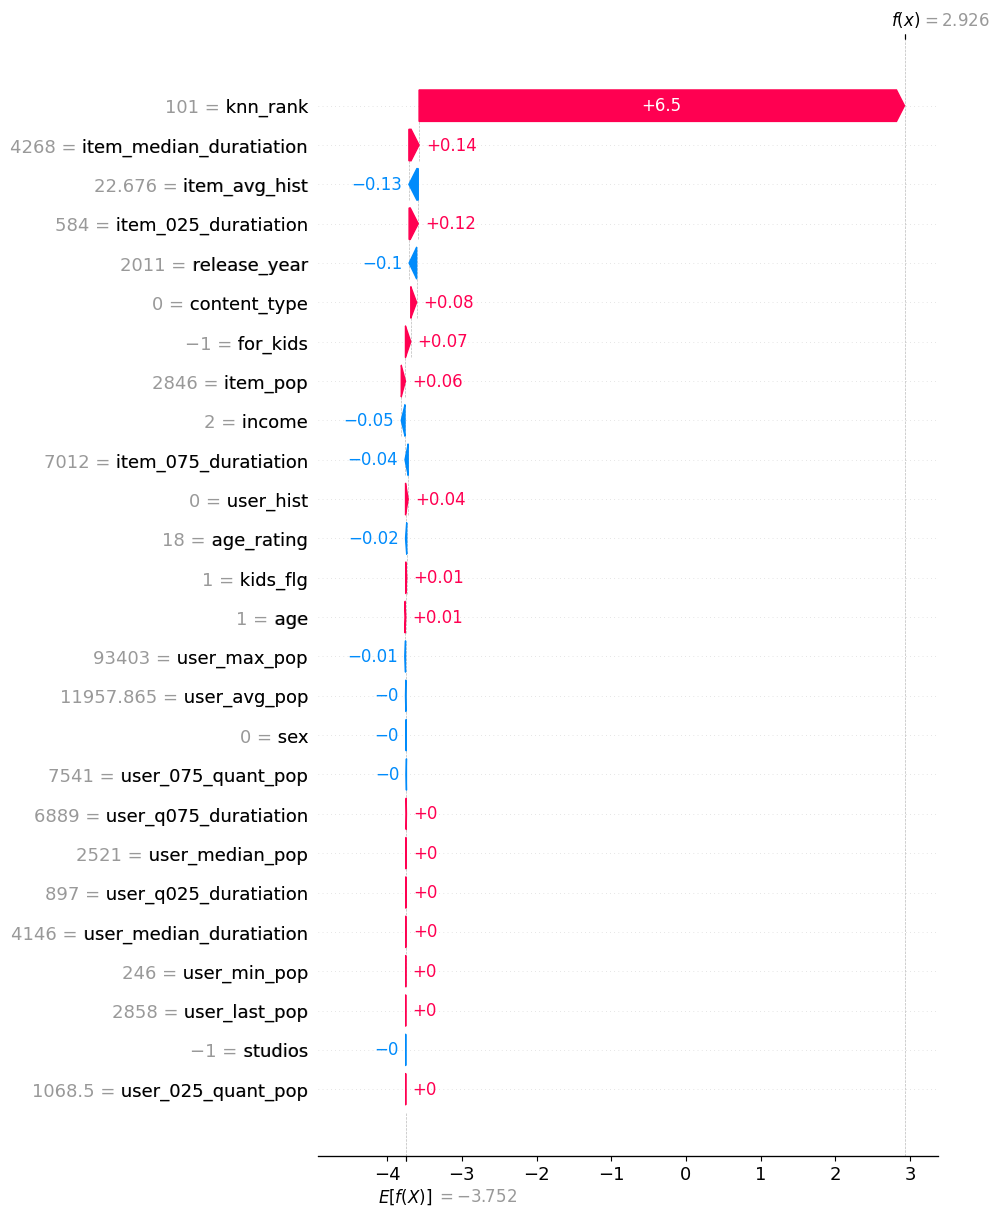

In [49]:
explainer = shap.Explainer(listwise_model)
shap_values = explainer(ranker_test[cols].iloc[:10_000])

shap.plots.waterfall(shap_values[0], max_display=len(cols))

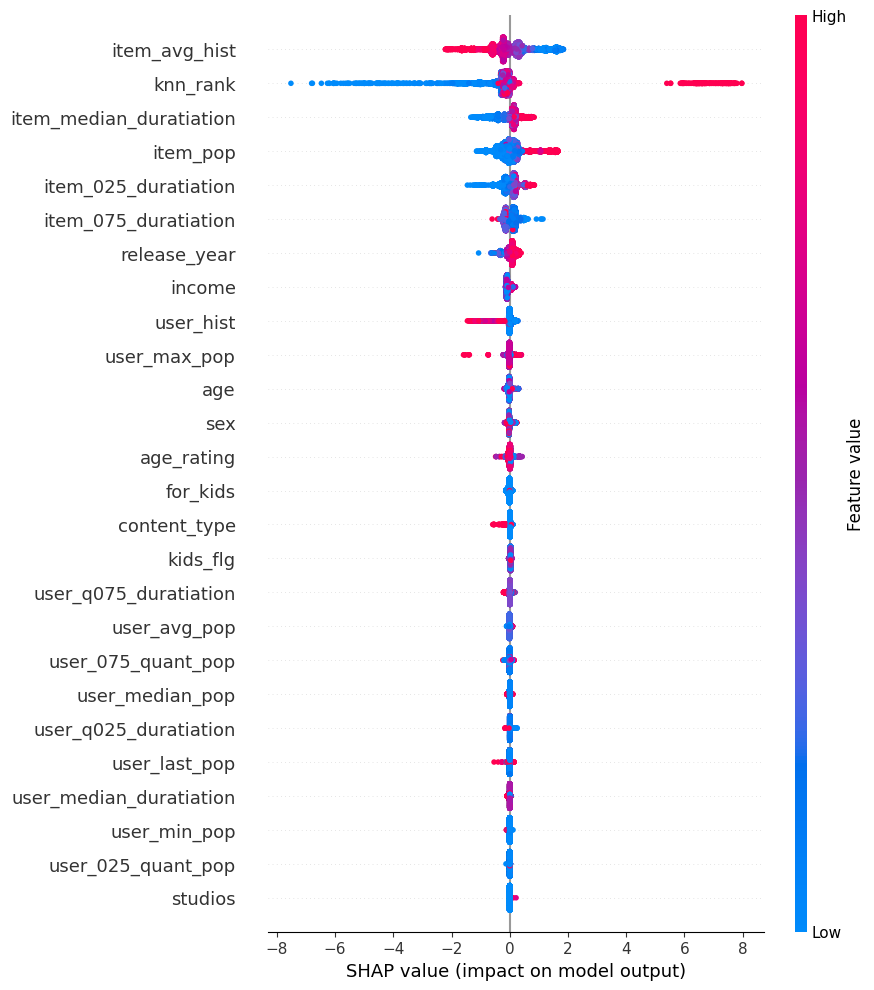

In [50]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=len(cols))

In [32]:
y_pred: np.ndarray = listwise_model.predict(ranker_test[cols])
ranker_test = add_score_and_rank(ranker_test, y_pred, 'listwise')
ranker_test.head(3)

,user_id,item_id,datetime,total_dur,weight,knn_rank,age,income,sex,kids_flg,...,item_pop,item_avg_hist,item_median_duratiation,item_025_duratiation,item_075_duratiation,target_ranker,listwise_score,listwise_rank,listwise_hybrid_score,listwise_hybrid_rank
15,1,3669,2021-08-16,1593.0,26.0,101.0,1,2,0,1,...,2846.0,22.675978,4268.0,584.00,7012.0,1,2.748616,1,-19.168196,101
94,1,15297,2021-07-01,0.0,0.0,5.0,1,2,0,1,...,137128.0,7.364295,21818.5,7137.75,30687.0,0,0.542928,2,0.542928,2
60,1,10440,2021-08-13,19579.0,80.0,8.0,1,2,0,1,...,141889.0,8.068716,24330.0,3500.00,40322.0,2,0.504057,3,0.504057,3


In [62]:
ranker_test[ranker_test.user_id == 1].sort_values(by = 'listwise_hybrid_rank')

,user_id,item_id,datetime,total_dur,weight,knn_rank,age,income,sex,kids_flg,...,target,pointwise_score,pointwise_rank,pointwise_hybrid_score,pointwise_hybrid_rank,target_ranker,listwise_score,listwise_rank,listwise_hybrid_score,listwise_hybrid_rank
94,1,15297,2021-07-01,0.0,0.0,5.0,1,2,0,1,...,0,0.086521,2,0.086521,2,0,0.542928,2,0.542928,2
60,1,10440,2021-08-13,19579.0,80.0,8.0,1,2,0,1,...,1,0.079407,3,0.079407,3,2,0.504057,3,0.504057,3
57,1,9728,2021-07-01,0.0,0.0,2.0,1,2,0,1,...,0,0.063357,4,0.063357,4,0,0.108057,4,0.108057,4
16,1,3734,2021-07-01,0.0,0.0,3.0,1,2,0,1,...,0,0.044763,5,0.044763,5,0,-0.514344,5,-0.514344,5
84,1,13865,2021-07-01,0.0,0.0,1.0,1,2,0,1,...,0,0.034935,6,0.034935,6,0,-0.684751,6,-0.684751,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,1,14717,2021-07-01,0.0,0.0,50.0,1,2,0,1,...,0,0.000152,98,0.000152,98,0,-5.791813,98,-5.791813,98
34,1,5873,2021-07-01,0.0,0.0,100.0,1,2,0,1,...,0,0.000297,94,0.000297,94,0,-5.867301,99,-5.867301,99
45,1,7460,2021-07-01,0.0,0.0,29.0,1,2,0,1,...,0,0.000123,100,0.000123,100,0,-6.072857,100,-6.072857,100
15,1,3669,2021-08-16,1593.0,26.0,101.0,1,2,0,1,...,0,0.428389,1,-0.001000,101,1,2.748616,1,-19.168196,101


In [60]:
y_pred

array([ 2.7486157 ,  0.54292794,  0.50405678, ..., -6.66454692,
       -6.062935  , -5.05943539])

In [53]:
models_metrics['listwise'] = calc_metrics_(ranker_test, 'listwise_rank')
models_metrics['listwise_hybrid'] = calc_metrics_(ranker_test, 'listwise_hybrid_rank')
pd.DataFrame(models_metrics)[['listwise', 'listwise_hybrid']]

,listwise,listwise_hybrid
Precision@10,0.276730,0.056406
recall@10,0.824714,0.278818
ndcg@10,0.371164,0.063102
map@10,0.704004,0.136064
novelty@10,4.570098,3.044439


In [54]:
(
    avg_user_metric(
        y_true=np.array(ranker_test['target']),  # target_ranker
        y_pred=np.array(ranker_test['listwise_score']),
        user_ids=np.array(ranker_test['user_id']),
        metric_function=roc_auc_score,
    ),
    avg_user_metric(
        y_true=np.array(ranker_test['target']),
        y_pred=np.array(ranker_test['listwise_hybrid_score']),
        user_ids=np.array(ranker_test['user_id']),
        metric_function=roc_auc_score,
    ),
)

(0.9378088980979155, 0.40079971118997665)